# Курсовой проект

#### Задача

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

#### Целевая переменная

Credit Default - факт невыполнения кредитных обязательств

#### Метрика качества

F1-score (sklearn.metrics.f1_score)

#### Требования к решению

Целевая метрика

* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)


**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

### Подключение библиотек и скриптов

In [554]:
import numpy as np
import pandas as pd
import pickle

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 10})

#### функция вывода метрик

In [555]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

#### функция устранения дисбаланса

In [556]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [557]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [558]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [559]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (10, len(feature_importances) * 0.5))
    
    sns.barplot(x = feature_importances['importance'], y = feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

### Загрузка данных

In [560]:
TRAIN_DATASET_PATH = 'files/course_project_train.csv'
TEST_DATASET_PATH = 'files/course_project_test.csv'

# output
MODEL_FILE_PATH = 'model/model.pkl'
SCALER_FILE_PATH = 'scaler.pkl'

In [561]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

### Первичный анализ данных

In [562]:
df_train.shape, df_test.shape

((7500, 17), (2500, 16))

In [563]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [564]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

In [565]:
for cat_colname in df_test.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_test[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    1225
Rent             1020
Own Home          248
Have Mortgage       7
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    810
3 years      228
2 years      212
< 1 year     207
5 years      169
1 year       153
4 years      152
7 years      140
6 years      137
8 years      107
9 years       99
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      1973
other                    240
home improvements        140
buy a car                 34
business loan             30
medical bills             27
buy house                 19
take a trip               14
major purchase             9
small business             5
educational expenses       3
vacation                   3
wedding                    2
moving               

In [566]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

#### Наблюдается дисбаланс данных.

In [567]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


### Обработка выбросов

In [568]:
def ejection (data_df):
    df = data_df.copy()
    cla = np.percentile(df['Current Loan Amount'], 85)
    moc = np.percentile(df['Maximum Open Credit'], 99)
    df.loc[df['Annual Income'] > 2350000, 'Annual Income'] = df['Annual Income'].mean()
    df.loc[df['Number of Open Accounts'] > 20, 'Number of Open Accounts'] = df['Number of Open Accounts'].mean()
    df.loc[df['Years of Credit History'] > 31, 'Years of Credit History'] = df['Years of Credit History'].mean()
    df.loc[df['Maximum Open Credit'] > 1290000, 'Maximum Open Credit'] = df['Maximum Open Credit'].mean()
    df.loc[df['Months since last delinquent'] > 117, 'Months since last delinquent'] = df['Months since last delinquent'].mean()
    df.loc[df['Current Loan Amount'] > 1650000, 'Current Loan Amount'] = df['Current Loan Amount'].mean()
    df.loc[df['Current Credit Balance'] > 515000, 'Current Credit Balance'] = df['Current Credit Balance'].mean()
    df.loc[df['Monthly Debt'] > 39000, 'Monthly Debt'] = df['Monthly Debt'].mean()
    df.loc[(df['Credit Score'] > 1100) | (df['Credit Score'] < 695), 'Credit Score'] = df['Credit Score'].mean()

    df['ID'] = df.index.tolist()
    return df

In [569]:
df_train = ejection(df_train)
df_test = ejection(df_test)

### Обработка пропусков

In [570]:
len(df_train) - df_train.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
ID                                 0
dtype: int64

In [571]:
def missing (data_df):
    df = data_df.copy()
    df['Annual Income'] = df['Annual Income'].fillna(df['Annual Income'].median())
    df['Credit Score'] = df['Credit Score'].fillna(df['Credit Score'].median())
    df['Bankruptcies'] = df['Bankruptcies'].fillna(0)
    df['Years in current job'] = df['Years in current job'].fillna('< 1 year') 
    df['Months since last delinquent'].fillna(df['Months since last delinquent'].median(), inplace=True)

    return df

In [572]:
df_train = missing(df_train)
df_test = missing(df_test)

In [573]:
len(df_train) - df_train.count()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
ID                              0
dtype: int64

### Добавление и отбор признаков

In [574]:
df_train['Term'] = pd.Series(df_train['Term'].map({'Short Term': 0, 'Long Term': 1}), dtype=np.float64)
df_test['Term'] = pd.Series(df_test['Term'].map({'Short Term': 0, 'Long Term': 1}), dtype=np.float64)

#### Новый признак - 1/0 (задолженость/отсутствие задолженности)

In [575]:
df_train['has_delay'] = 1
df_train.loc[(df_train['Months since last delinquent'] == 0), 'has_delay'] = 0

#### Новый признак о неизвестном доходе 1/0 (доход известен/доход не известен)


In [576]:
df_train['unknown_income'] = 0
df_train.loc[(df_train['Annual Income'].isnull()), 'unknown_income'] = 1

In [577]:
df_test['has_delay']= df_train['has_delay']
df_test['unknown_income']= df_train['unknown_income']

#### Dummies

In [578]:
for cat_colname in df_train.select_dtypes(include='object').columns[1:]:
    df_train = pd.concat([df_train, pd.get_dummies(df_train[cat_colname], prefix=cat_colname)], axis=1)

In [579]:
for cat_colname in df_test.select_dtypes(include='object').columns[1:]:
    df_test = pd.concat([df_test, pd.get_dummies(df_test[cat_colname], prefix=cat_colname)], axis=1)

In [580]:
df_train = pd.concat([df_train, pd.get_dummies(df_train['Home Ownership'], prefix='Home Ownership')], axis=1)

In [581]:
df_test = pd.concat([df_test, pd.get_dummies(df_test['Home Ownership'], prefix='Home Ownership')], axis=1)

#### Корреляция с целевым признаком

Text(0.5, 1.0, 'Correlation with TARGET variable')

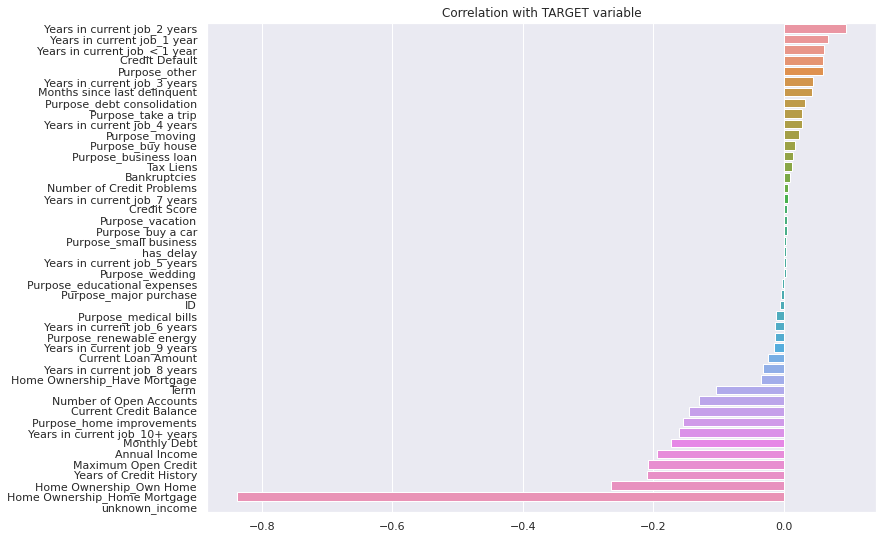

In [582]:
sns.set(font_scale=1)
corr_with_TARGET = df_train.corr().iloc[:-1, -1].sort_values(ascending=False)
plt.figure(figsize=(12, 9))
sns.barplot(x=corr_with_TARGET.values, y=corr_with_TARGET.index)
plt.title('Correlation with TARGET variable')

In [583]:
TARGET_NAME = 'Credit Default'
NUM_FEATURE_NAMES = ['Annual Income','Tax Liens','Number of Open Accounts','Years of Credit History',
                     'Maximum Open Credit','Number of Credit Problems','Months since last delinquent',
                     'Bankruptcies','Term','Current Loan Amount','Current Credit Balance','Monthly Debt','Credit Score']
CAT_FEATURE_NAMES = ['Years in current job','Home Ownership','Purpose']
NEW_FEATURE_NAMES = ['unknown_income','has_delay', 'Home Ownership_Have Mortgage', 'Home Ownership_Home Mortgage',
                     'Home Ownership_Own Home', 'Home Ownership_Rent','Years in current job_1 year', 'Years in current job_10+ years',
                    'Years in current job_2 years','Years in current job_3 years','Years in current job_4 years','Years in current job_5 years',
                    'Years in current job_6 years','Years in current job_7 years','Years in current job_8 years','Years in current job_9 years',
                    'Years in current job_< 1 year','Purpose_business loan','Purpose_buy a car','Purpose_buy house','Purpose_debt consolidation',
                    'Purpose_educational expenses','Purpose_home improvements','Purpose_major purchase','Purpose_medical bills','Purpose_moving',
                    'Purpose_other','Purpose_small business','Purpose_take a trip','Purpose_vacation','Purpose_wedding']
SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + NEW_FEATURE_NAMES


### Приведение типов для модели CatBoost

In [584]:
for colname in CAT_FEATURE_NAMES:
    df_train[colname] = pd.Categorical(df_train[colname])
    
df_train[CAT_FEATURE_NAMES].dtypes

Years in current job    category
Home Ownership          category
Purpose                 category
dtype: object

In [585]:
for colname in CAT_FEATURE_NAMES:
    df_test[colname] = pd.Categorical(df_test[colname])
    
df_test[CAT_FEATURE_NAMES].dtypes

Years in current job    category
Home Ownership          category
Purpose                 category
dtype: object

### Нормализация данных

In [586]:
scaler = StandardScaler()

df_norm = df_train.copy()
df_norm[SELECTED_FEATURE_NAMES] = scaler.fit_transform(df_norm[SELECTED_FEATURE_NAMES])

df_train = df_norm.copy()

In [587]:
scaler = StandardScaler()

df_norm = df_test.copy()
df_norm[SELECTED_FEATURE_NAMES] = scaler.fit_transform(df_norm[SELECTED_FEATURE_NAMES])

df_test = df_norm.copy()

In [588]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

### Разбиение на train и test

In [589]:
X = df_train.drop(columns=CAT_FEATURE_NAMES + ['ID', TARGET_NAME])
y = df_train[TARGET_NAME]

In [590]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

### Балансировка целевой переменной

In [591]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    3771
1    2958
Name: Credit Default, dtype: int64

In [592]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

### Построение и оценка базовых моделей

**Логистическая регрессия**

In [593]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.68      0.82      0.75      3771
           1       0.69      0.52      0.59      2958

    accuracy                           0.69      6729
   macro avg       0.69      0.67      0.67      6729
weighted avg       0.69      0.69      0.68      6729

TEST

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1616
           1       0.52      0.52      0.52       634

    accuracy                           0.73      2250
   macro avg       0.66      0.66      0.66      2250
weighted avg       0.73      0.73      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1310  306
1                307  327


**k ближайших соседей**

In [594]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.78      0.84      0.81      3771
           1       0.77      0.70      0.74      2958

    accuracy                           0.78      6729
   macro avg       0.78      0.77      0.77      6729
weighted avg       0.78      0.78      0.78      6729

TEST

              precision    recall  f1-score   support

           0       0.77      0.74      0.75      1616
           1       0.40      0.44      0.42       634

    accuracy                           0.65      2250
   macro avg       0.58      0.59      0.58      2250
weighted avg       0.66      0.65      0.66      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1196  420
1                358  276


**Бустинговые алгоритмы**

*XGBoost*

In [595]:
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

ValueError: feature_names must be string, and may not contain [, ] or <

*LightGBM*

In [596]:
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.91      0.92      0.92      3771
           1       0.90      0.89      0.89      2958

    accuracy                           0.91      6729
   macro avg       0.91      0.91      0.91      6729
weighted avg       0.91      0.91      0.91      6729

TEST

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1616
           1       0.51      0.52      0.52       634

    accuracy                           0.73      2250
   macro avg       0.66      0.66      0.66      2250
weighted avg       0.73      0.73      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1304  312
1                304  330


*CatBoost*

In [597]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.89      0.92      0.90      3771
           1       0.89      0.85      0.87      2958

    accuracy                           0.89      6729
   macro avg       0.89      0.89      0.89      6729
weighted avg       0.89      0.89      0.89      6729

TEST

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1616
           1       0.51      0.50      0.51       634

    accuracy                           0.73      2250
   macro avg       0.66      0.66      0.66      2250
weighted avg       0.72      0.73      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1315  301
1                315  319


### Выбор наилучшей модели, настройка гиперпараметров

In [598]:
model_catb = catb.CatBoostClassifier(class_weights=[1, 3.5], silent=True, random_state=21)

In [599]:
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500],
          'max_depth':[3, 5, 7]}

In [600]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [601]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)

CPU times: user 7.59 s, sys: 1.11 s, total: 8.69 s
Wall time: 50.4 s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x7f93895790c0>,
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 7],
                                        'n_estimators': [50, 100, 200, 500, 700,
                                                         1000, 1200, 1500]},
                   scoring='f1')

In [602]:
rs.best_params_

{'n_estimators': 700, 'max_depth': 5}

In [603]:
rs.best_score_

0.5461130076028149

**Обучение и оценка финальной модели**

In [604]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=700, max_depth=5,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      3771
           1       0.84      0.78      0.81      2958

    accuracy                           0.84      6729
   macro avg       0.84      0.83      0.83      6729
weighted avg       0.84      0.84      0.84      6729

TEST

              precision    recall  f1-score   support

           0       0.82      0.81      0.82      1616
           1       0.53      0.54      0.54       634

    accuracy                           0.74      2250
   macro avg       0.67      0.68      0.68      2250
weighted avg       0.74      0.74      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1313  303
1                291  343
CPU times: user 7.11 s, sys: 953 ms, total: 8.07 s
Wall time: 1.42 s


### Проверка качества, борьба с переобучением

In [614]:
final_model = catb.CatBoostClassifier(n_estimators=700, max_depth=5,
                                      l2_leaf_reg=10,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.71      0.84      0.77      3771
           1       0.74      0.56      0.64      2958

    accuracy                           0.72      6729
   macro avg       0.72      0.70      0.71      6729
weighted avg       0.72      0.72      0.71      6729

TEST

              precision    recall  f1-score   support

           0       0.81      0.82      0.82      1616
           1       0.54      0.52      0.53       634

    accuracy                           0.74      2250
   macro avg       0.68      0.67      0.67      2250
weighted avg       0.74      0.74      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1330  286
1                302  332


In [615]:
final_model = catb.CatBoostClassifier(n_estimators=700, max_depth=5,
                                      class_weights=[1, 3.5],
                                      silent=True, random_state=21)

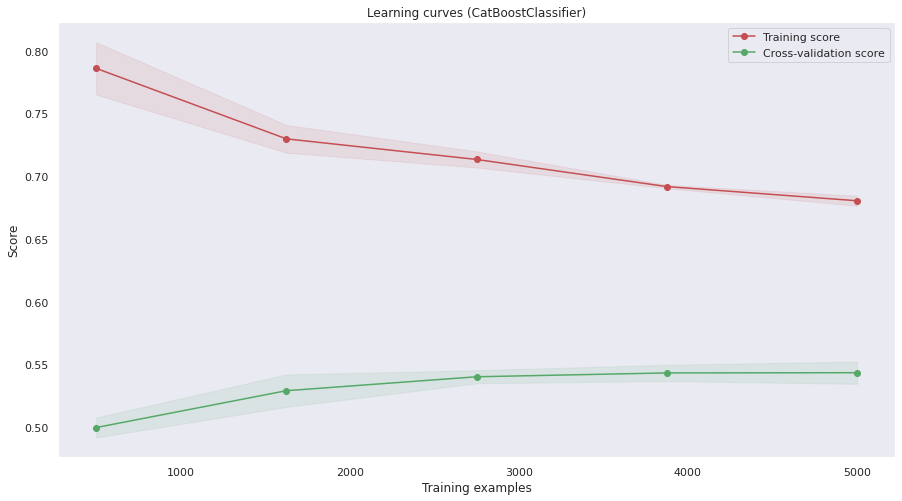

In [616]:
show_learning_curve_plot(final_model, X, y)

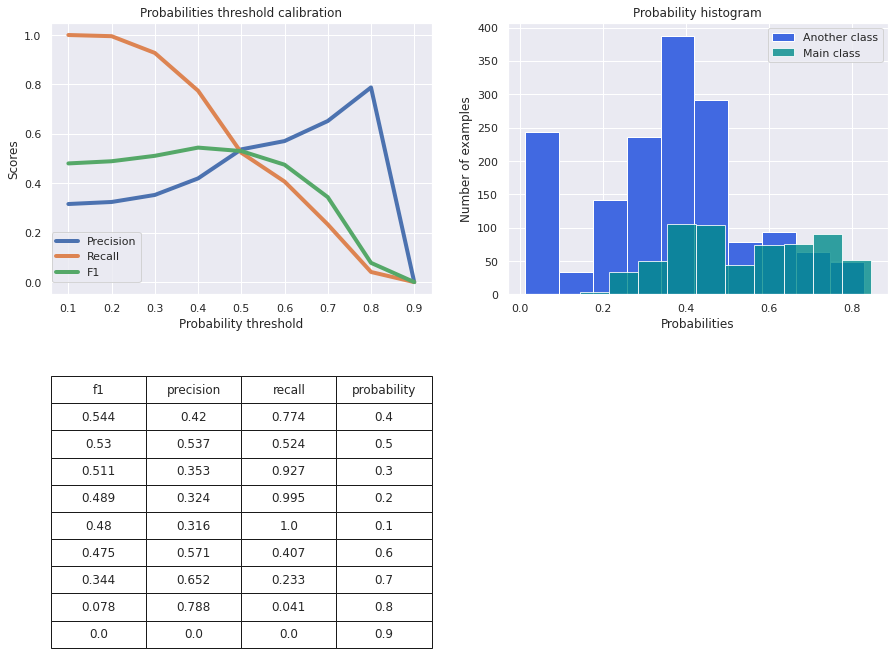

In [617]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

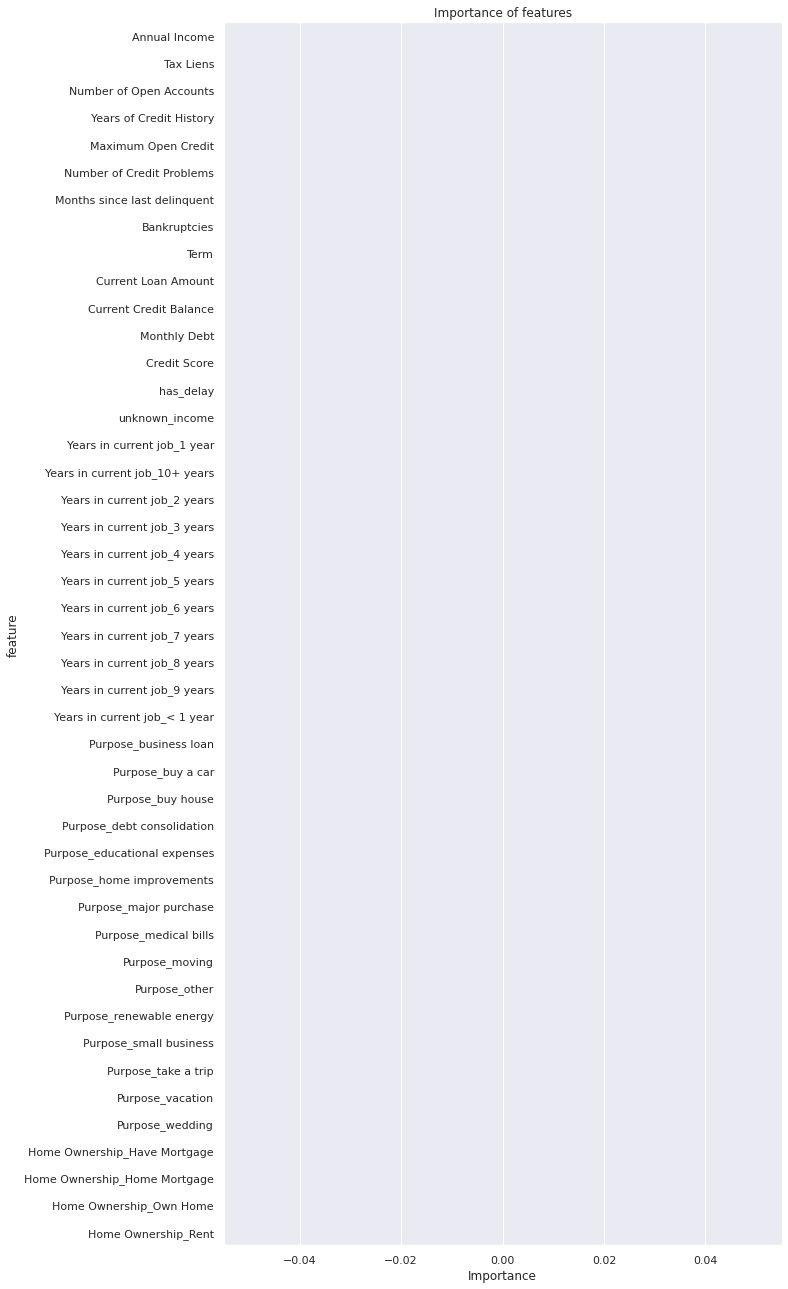

In [618]:
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=15)

In [610]:
important_features_top

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'has_delay',
 'unknown_income']

In [619]:
final_model = catb.CatBoostClassifier(n_estimators=700, max_depth=5, l2_leaf_reg=10,
                                      silent=True, random_state=21)
final_model.fit(X_train[important_features_top], y_train)

y_train_pred = final_model.predict(X_train[important_features_top])
y_test_pred = final_model.predict(X_test[important_features_top])
y_test_pred_probs = final_model.predict_proba(X_test[important_features_top])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.71      0.84      0.77      3771
           1       0.74      0.56      0.63      2958

    accuracy                           0.72      6729
   macro avg       0.72      0.70      0.70      6729
weighted avg       0.72      0.72      0.71      6729

TEST

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1616
           1       0.54      0.52      0.53       634

    accuracy                           0.74      2250
   macro avg       0.68      0.67      0.68      2250
weighted avg       0.74      0.74      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1333  283
1                302  332


### Сохранение финальной модели

In [543]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

## Интерпретация результатов

CatBoost и LightGBM с f1-score 0.51 и 0.52 соответсвенно. Для дальшейшей работы была выбрана модель CatBoost. Примечательно, что борьба с переобучением иногда приводила к ухудшению результата. Да и выбор параметров тоже не назвал бы оптимальным решением.
В целом могу отметить, что результаты можно улучшить более правильно, чем просто в лоб (как я это делал). Поработать с выбросами, пропущенными данным и более лучше поработать с новыми признаками и отбором этого всего в итоговую модель.

## Предсказание на test

In [550]:
test_output = final_model.predict(df_test[SELECTED_FEATURE_NAMES])

In [551]:
result=pd.DataFrame({'Id':np.arange(2500), 'Credit Default': test_output})

In [552]:
RESULT_PATH='VIvanov_predictions.csv'
result.to_csv(RESULT_PATH, index=False)

In [553]:
result.head()

,Id,Credit Default
0,0,0
1,1,0
2,2,1
3,3,0
4,4,0
